In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Conv1D, LSTM
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
df = pd.read_csv('reddit_pushshift_dropped_irrelevant.csv')

In [3]:
df

,movie_name,genre,original_language,popularity,release_date,vote_average,vote_count,revenue,runtime,author,score,link_id,body,utc_datetime_str,"subjectivity \n{0: neutral,1\n: subjective}","polarity \n{0: negative, \n1: positive, \n2: neutral}",to remove useless comment \n(0: useful \n1: useless)
0,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,Whale31777,1.0,t3_10z5t71,Im just happy to see you Avatar 2.,11/2/2023 6:01,1.0,1.0,0.0
1,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,njdevils901,1.0,t3_10za4qa,holy shit someone on /r/movies understands why...,11/2/2023 4:17,1.0,1.0,0.0
2,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,Icy-Exchange6457,1.0,t3_10z2ctw,Avatar 2. Absolutely loved the first one and I...,11/2/2023 3:05,1.0,0.0,0.0
3,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,FortitudeWisdom,1.0,t3_10z61yi,"This movie did surprised me. A good film, but ...",11/2/2023 0:27,1.0,1.0,0.0
4,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,yousyveshughs,1.0,t3_10yfvyj,The Batman kinda sucked though. It was boring ...,10/2/2023 20:05,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28459,A Madea Family Funeral,Comedy,en,13.689,3/1/2019,5.9,435.0,46115383.0,104.0,Wehavecrashed,1.0,t3_ay9785,You could just not be informed. It is just a m...,14/3/2019 5:44,NaN,NaN,NaN
28460,A Madea Family Funeral,Comedy,en,13.689,3/1/2019,5.9,435.0,46115383.0,104.0,haunthorror,21.0,t3_ae0vih,There is possibly going to be 4 straight weeks...,9/1/2019 1:21,NaN,NaN,NaN
28461,A Madea Family Funeral,Comedy,en,13.689,3/1/2019,5.9,435.0,46115383.0,104.0,JustOneSexQuestion,24.0,t3_9y1p99,You made me check. A Madea Family Funeral rele...,18/11/2018 3:31,NaN,NaN,NaN
28462,A Madea Family Funeral,Comedy,en,13.689,3/1/2019,5.9,435.0,46115383.0,104.0,aquamarinerock,1.0,t3_9ssids,"The next, and apparently last, Madea movie is ...",31/10/2018 5:20,NaN,NaN,NaN


# Data Processing

In [4]:
df.isnull().values.any()

True

In [5]:
df = df.dropna().reset_index(drop=True)
df

,movie_name,genre,original_language,popularity,release_date,vote_average,vote_count,revenue,runtime,author,score,link_id,body,utc_datetime_str,"subjectivity \n{0: neutral,1\n: subjective}","polarity \n{0: negative, \n1: positive, \n2: neutral}",to remove useless comment \n(0: useful \n1: useless)
0,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,Whale31777,1.0,t3_10z5t71,Im just happy to see you Avatar 2.,11/2/2023 6:01,1.0,1.0,0.0
1,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,njdevils901,1.0,t3_10za4qa,holy shit someone on /r/movies understands why...,11/2/2023 4:17,1.0,1.0,0.0
2,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,Icy-Exchange6457,1.0,t3_10z2ctw,Avatar 2. Absolutely loved the first one and I...,11/2/2023 3:05,1.0,0.0,0.0
3,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,FortitudeWisdom,1.0,t3_10z61yi,"This movie did surprised me. A good film, but ...",11/2/2023 0:27,1.0,1.0,0.0
4,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,14/12/2022,0.0,0.0,0.0,0.0,yousyveshughs,1.0,t3_10yfvyj,The Batman kinda sucked though. It was boring ...,10/2/2023 20:05,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,The Invisible Man,"Thriller, Science Fiction, Horror",en,29.875,2/26/2020,7.2,4135.0,130234661.0,124.0,HerpankerTheHardman,1.0,t3_zgvs75,The last film I saw in the theaters where it w...,9/12/2022 17:34,1.0,1.0,0.0
3947,Red Son,"Science Fiction, Animation, Action",en,20.874,2/24/2020,7.3,614.0,0.0,84.0,debtRiot,1.0,t3_10q48lk,Red Son is such an amazing concept but such a ...,1/2/2023 5:51,1.0,1.0,0.0
3948,Red Son,"Science Fiction, Animation, Action",en,20.874,2/24/2020,7.3,614.0,0.0,84.0,nerds-and-birds,1.0,t3_10q48lk,Red Son would be amazing. I love that story. H...,1/2/2023 1:03,1.0,2.0,0.0
3949,Red Son,"Science Fiction, Animation, Action",en,20.874,2/24/2020,7.3,614.0,0.0,84.0,the_421_Rob,1.0,t3_ywdbag,I love the what if stuff Im not a big Superman...,16/11/2022 0:40,1.0,1.0,0.0


In [6]:
df.shape

(3951, 17)

In [7]:
df['body'][0]

'Im just happy to see you Avatar 2.'

Text(0.5, 1.0, 'Polarity')

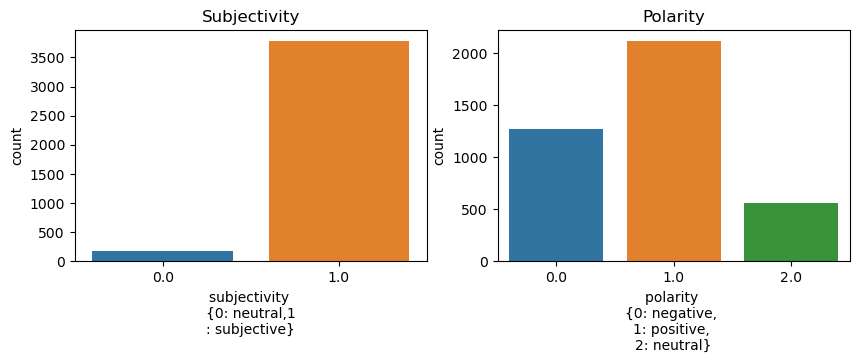

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(x='subjectivity \n{0: neutral,1\n: subjective}', data=df, ax=axs[0])
sns.countplot(x='polarity \n{0: negative, \n1: positive, \n2: neutral}', data=df, ax=axs[1])

axs[0].set_title('Subjectivity')
axs[1].set_title('Polarity')

In [9]:
grps = ['subjectivity \n{0: neutral,1\n: subjective}', 'polarity \n{0: negative, \n1: positive, \n2: neutral}']

for col_name in grps:
    counts = df[col_name].value_counts()
    print(f'\nFeature:{col_name}')
    print(counts)


Feature:subjectivity 
{0: neutral,1
: subjective}
1.0    3780
0.0     171
Name: subjectivity \n{0: neutral,1\n: subjective}, dtype: int64

Feature:polarity 
{0: negative, 
1: positive, 
2: neutral}
1.0    2117
0.0    1274
2.0     560
Name: polarity \n{0: negative, \n1: positive, \n2: neutral}, dtype: int64


In [10]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [11]:
# remove any sort of remaining tags
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [12]:
X = []
sentences = list(df['body'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [13]:
print(X)

['Im just happy to see you Avatar ', 'holy shit someone on movies understands why Avatar is successful this is groundbreaking stuff', 'Avatar Absolutely loved the first one and was so excited to see the sequel but it was overly long same story from the first just worst and the voiceover was so obnoxious Then saw Babylon and absolutely loved it and hated Avatar even more for stealing attention away from it ', 'This movie did surprised me good film but think right now there haven been lot of good movies that have come out recently The best lately seem to have been Dune Avatar and Topgun None of them are above for me Good movies and definitely worth watch but wouldn particularly recommend them to anyone ', 'The Batman kinda sucked though It was boring as hell and not very entertaining whereas could easily sit through Avatar many times and always leave satisfied ', 'His Dune review made me so mad but then he loved Avatar truly never know what to expect ', 'Looks better than Avatar ', 'I fe

In [14]:
X[0]

'Im just happy to see you Avatar '

In [15]:
# y = df['subjectivity \n{0: neutral,1\n: subjective}']

# y = np.array(list(map(lambda x: 1 if x=="subjective" else 0, y)))

y = df['polarity \n{0: negative, \n1: positive, \n2: neutral}'].values

# y = np.array(list(map(lambda x: 2 if x=='neutral' else 1 if x=='positive' else 0, y)))

In [16]:
print(y)

[1. 1. 0. ... 2. 1. 1.]


# Word embedding with GloVe from Stanford 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [18]:
tokenizer = Tokenizer(num_words=1000) # Total number of words to be considered in the tokenizer, changeable
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100 # Max length to consider in a single review, changeable

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:
import os
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

# Get the current working directory
cwd = os.getcwd()

# Define the relative path to the file
file_path = "glove.6B.100d.txt"

# Join the paths to create the full file path
full_path = os.path.join(cwd, file_path)

# Open the file using the full path
glove_file = open(full_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [21]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Testing using Simple Neural Network

In [22]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='softmax'))

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          969900    
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 979,901
Trainable params: 10,001
Non-trainable params: 969,900
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


C:\Users\TQ\anaconda3\envs\venv\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 2/6
20/20 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 3/6
20/20 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 4/6
20/20 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 5/6
20/20 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 6/6
20/20 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665


In [25]:
score = model.evaluate(X_test, y_test, verbose=1)

25/25 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - acc: 0.5360


In [26]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0
Test Accuracy: 0.5360303521156311


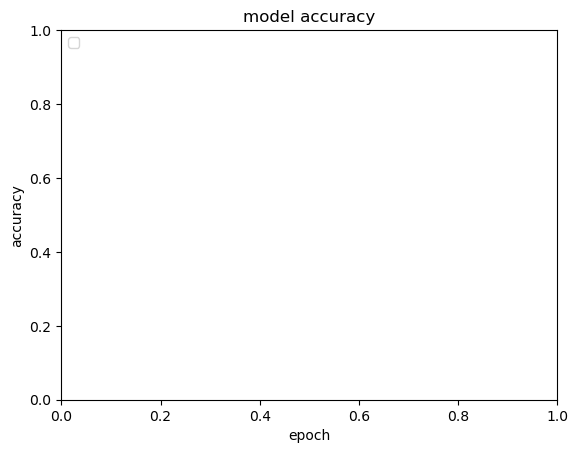

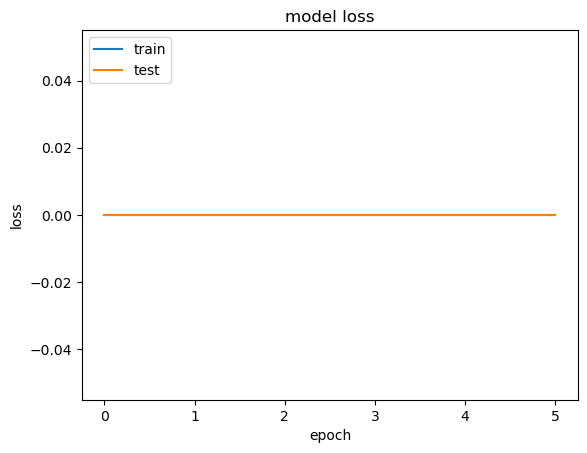

In [27]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Testing with RNN

In [28]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [29]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          969900    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,034,157
Trainable params: 64,257
Non-trainable params: 969,900
_________________________________________________________________
None


In [30]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
20/20 [==============================] - 2s 34ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 2/6
20/20 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 3/6
20/20 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 4/6
20/20 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 5/6
20/20 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 6/6
25/25 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - acc: 0.5360


In [31]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0
Test Accuracy: 0.5360303521156311


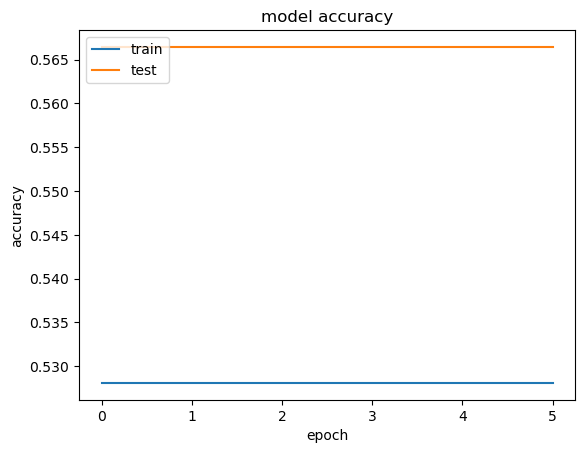

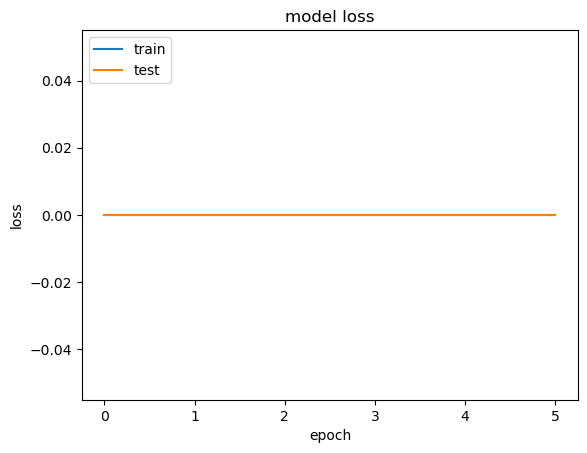

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Testing with LSTM

In [33]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [34]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          969900    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,087,277
Trainable params: 117,377
Non-trainable params: 969,900
_________________________________________________________________
None


In [35]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
20/20 [==============================] - 6s 207ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 2/6
20/20 [==============================] - 4s 193ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 3/6
20/20 [==============================] - 4s 187ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 4/6
20/20 [==============================] - 4s 194ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 5/6
20/20 [==============================] - 4s 210ms/step - loss: 0.0000e+00 - acc: 0.5281 - val_loss: 0.0000e+00 - val_acc: 0.5665
Epoch 6/6
25/25 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - acc: 0.5360


In [36]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0
Test Accuracy: 0.5360303521156311


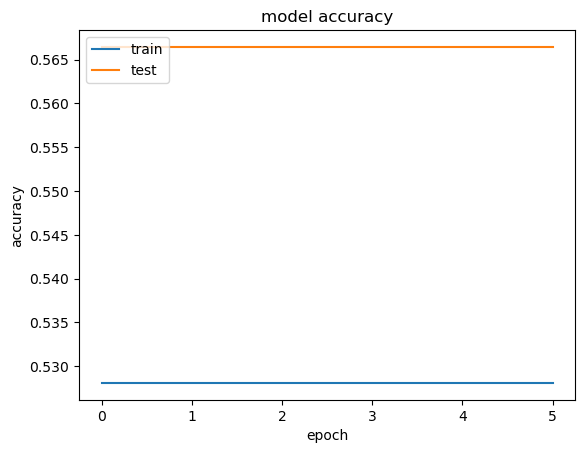

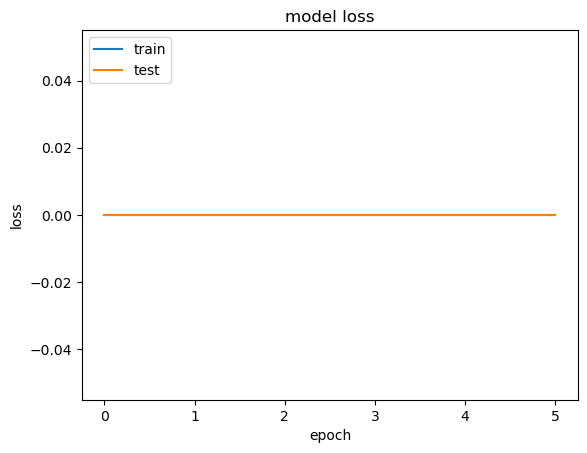

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Prediction on a single instance

In [38]:
instance = X[57]
print(instance)

Black Adam is the third good DCU film 


In [39]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

# 0: negative, 1: positive, 2: neutral
model.predict(instance)

1/1 [==============================] - 0s 496ms/step


array([[1.]], dtype=float32)